In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [2]:
learning_curves = {
    "VGG19": pd.read_csv("./results/vgg19_vgg19/20230510_172958.csv"),
    "VGG19_BN": pd.read_csv("./results/vgg19_bn_vgg19/20230525_045131.csv"),
    "ResNet50": pd.read_csv("./results/resnet50_vgg19/20230514_213740.csv"),
    "EfficientNetV2L": pd.read_csv("./results/efficientnetv2l_vgg19/20230525_194238.csv"),
}

save_folder = Path("./results/comparison/")

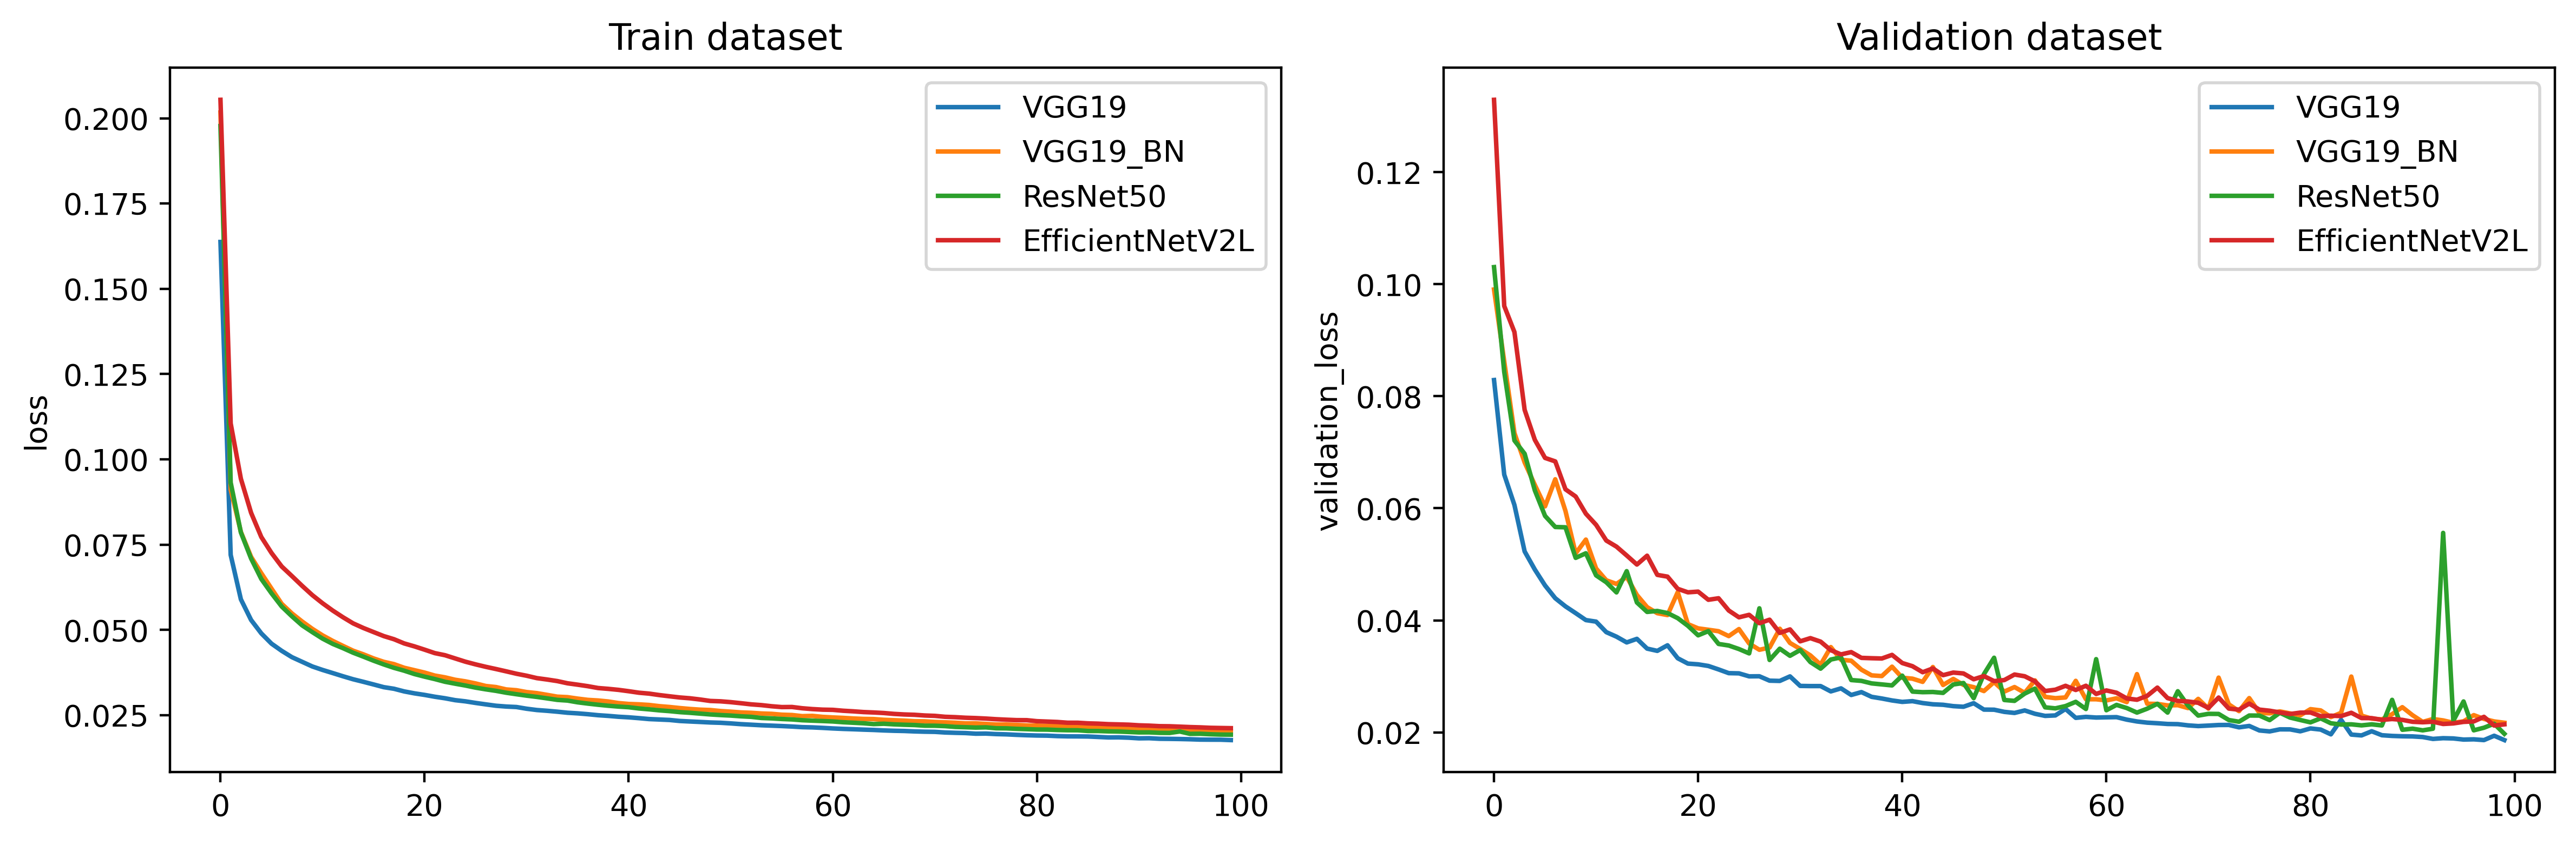

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=400, tight_layout=True)
for k, v in learning_curves.items():
    sns.lineplot(
        data=v,
        x=v.index,
        y="loss",
        label=k,
        ax=ax[0],
    )
    sns.lineplot(
        data=v,
        x=v.index,
        y="validation_loss",
        label=k,
        ax=ax[1],
    )
ax[0].set_title("Train dataset")
ax[1].set_title("Validation dataset")
plt.show()
fig.savefig(fname=save_folder / "learning_curves.png")

In [4]:
stdev = {k: v.rolling(window=10).std() for k, v in learning_curves.items()}

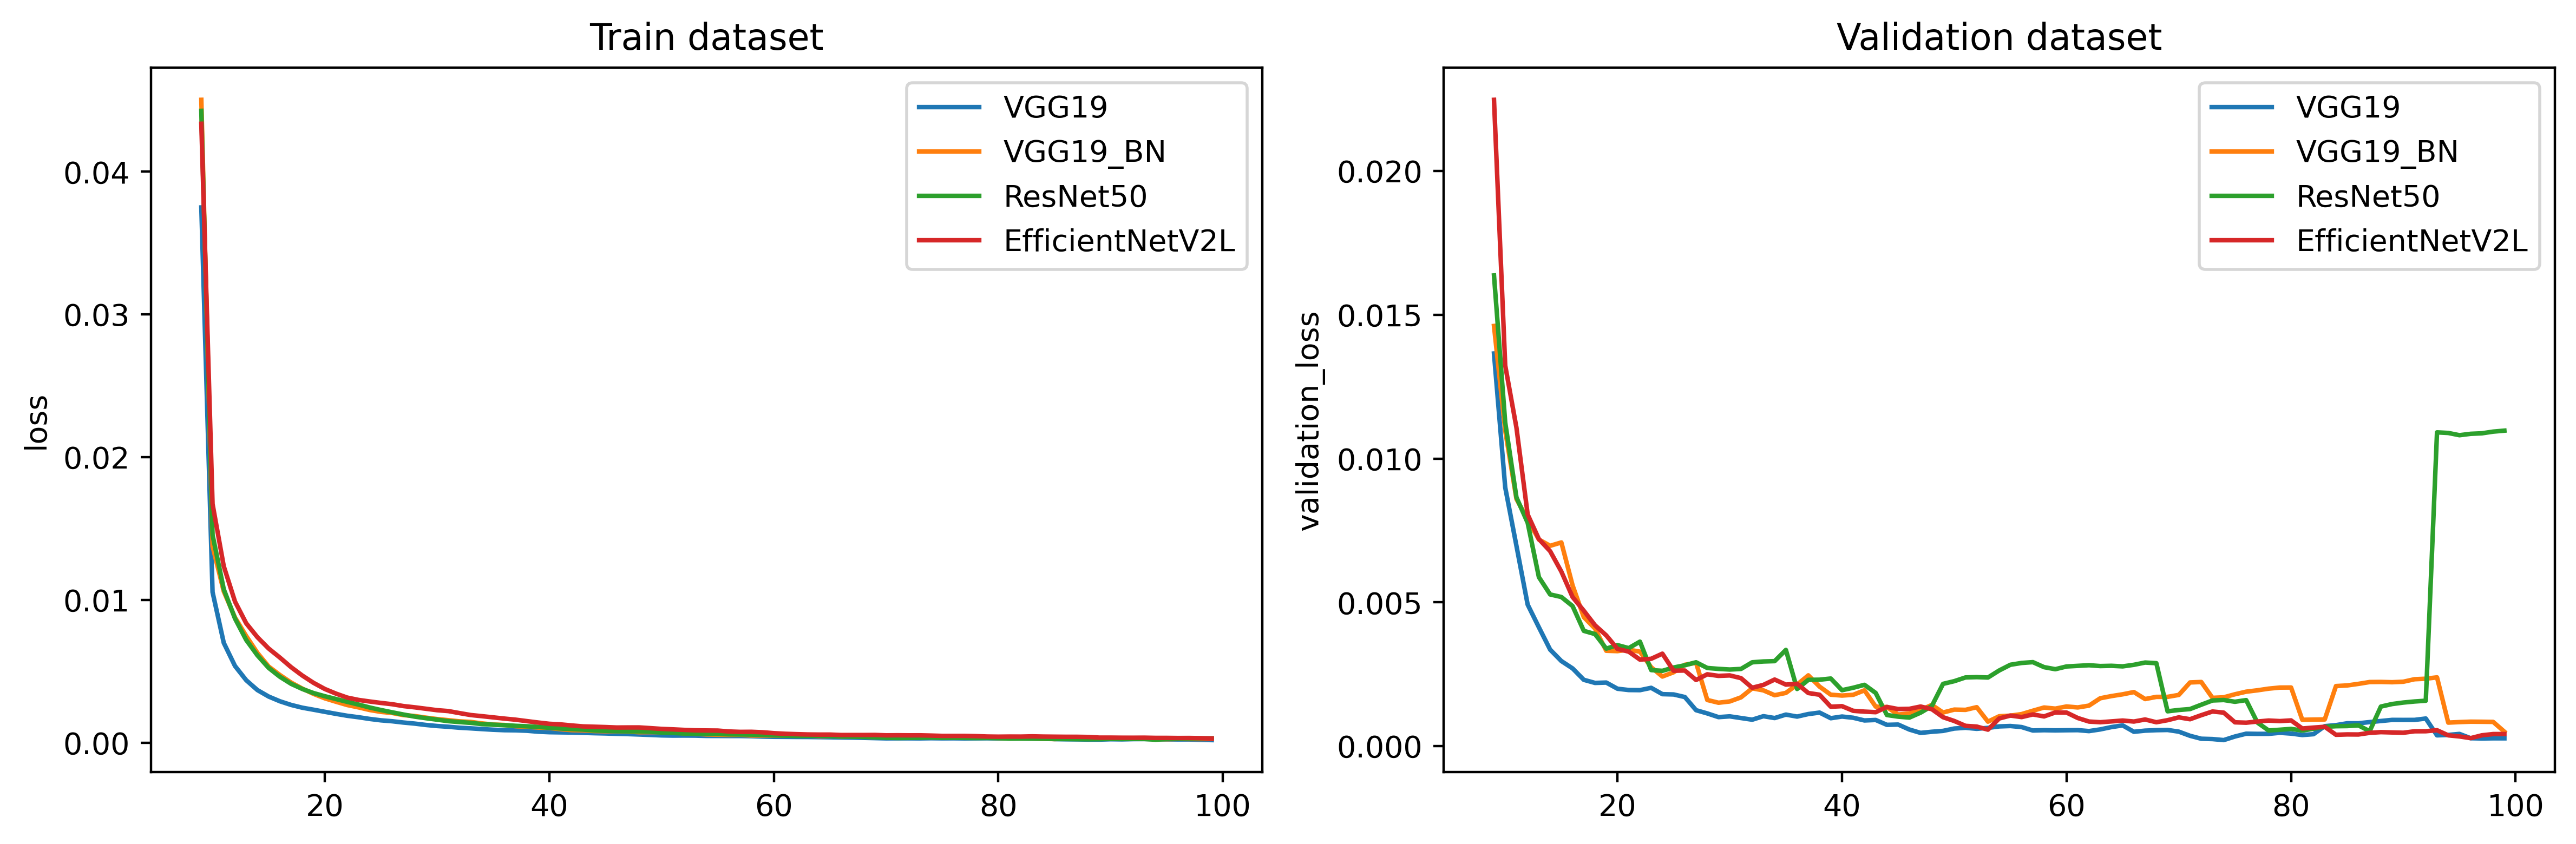

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=400, tight_layout=True)
for k, v in stdev.items():
    sns.lineplot(
        data=v,
        x=v.index,
        y="loss",
        label=k,
        ax=ax[0],
    )
    sns.lineplot(
        data=v,
        x=v.index,
        y="validation_loss",
        label=k,
        ax=ax[1],
    )
ax[0].set_title("Train dataset")
ax[1].set_title("Validation dataset")
plt.show()
fig.savefig(fname=save_folder / "stdevs.png")

In [6]:
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, f1_score
from toolkit.classes import DataFrameCreator

In [7]:
threshold_multipl = np.linspace(0, 3, 301, endpoint=True)

losses = {
    "VGG19": pd.read_csv("./results/vgg19_vgg19/20230510_172958_losses.csv", index_col="img_no"),
    "VGG19_BN": pd.read_csv("./results/vgg19_bn_vgg19/20230525_045131_losses.csv", index_col="img_no"),
    "ResNet50": pd.read_csv("./results/resnet50_vgg19/20230514_213740_losses.csv", index_col="img_no"),
    "EfficientNetV2L": pd.read_csv("./results/efficientnetv2l_vgg19/20230525_194238_losses.csv", index_col="img_no"),
}

data = DataFrameCreator()
data_folder = Path("./data/")
samples = ["sd1_sample"]

for sample in samples:
    data.load_dataset(
        sample_dir=data_folder / sample,
        labels={"normal": 0, "grass": 1, "double_rail": 2},
    )

y_true = data["dataset"]["label"] != "normal"

  0%|          | 0/8640 [00:00<?, ?it/s]

[    INFO    ] Images loaded from data/sd1_sample with label normal


  0%|          | 0/64 [00:00<?, ?it/s]

[    INFO    ] Images loaded from data/sd1_sample with label grass


  0%|          | 0/29 [00:00<?, ?it/s]

[    INFO    ] Images loaded from data/sd1_sample with label double_rail


In [8]:
res = {}
for k, loss in losses.items():
    res[k] = pd.DataFrame(columns=["Recall", "F1_score", "Balanced_acc"])
    loss_mean = np.mean(loss)
    loss_std = np.std(loss)
    for multipl in threshold_multipl:
        loss_threshold = loss_mean + multipl * loss_std
        y_pred = loss >= loss_threshold
        df = pd.DataFrame(
            data={
                "Recall": recall_score(y_true, y_pred),
                "F1_score": f1_score(y_true, y_pred),
                "Balanced_acc": balanced_accuracy_score(y_true, y_pred),
            },
            index=[multipl],
        )
        res[k] = pd.concat([res[k], df])

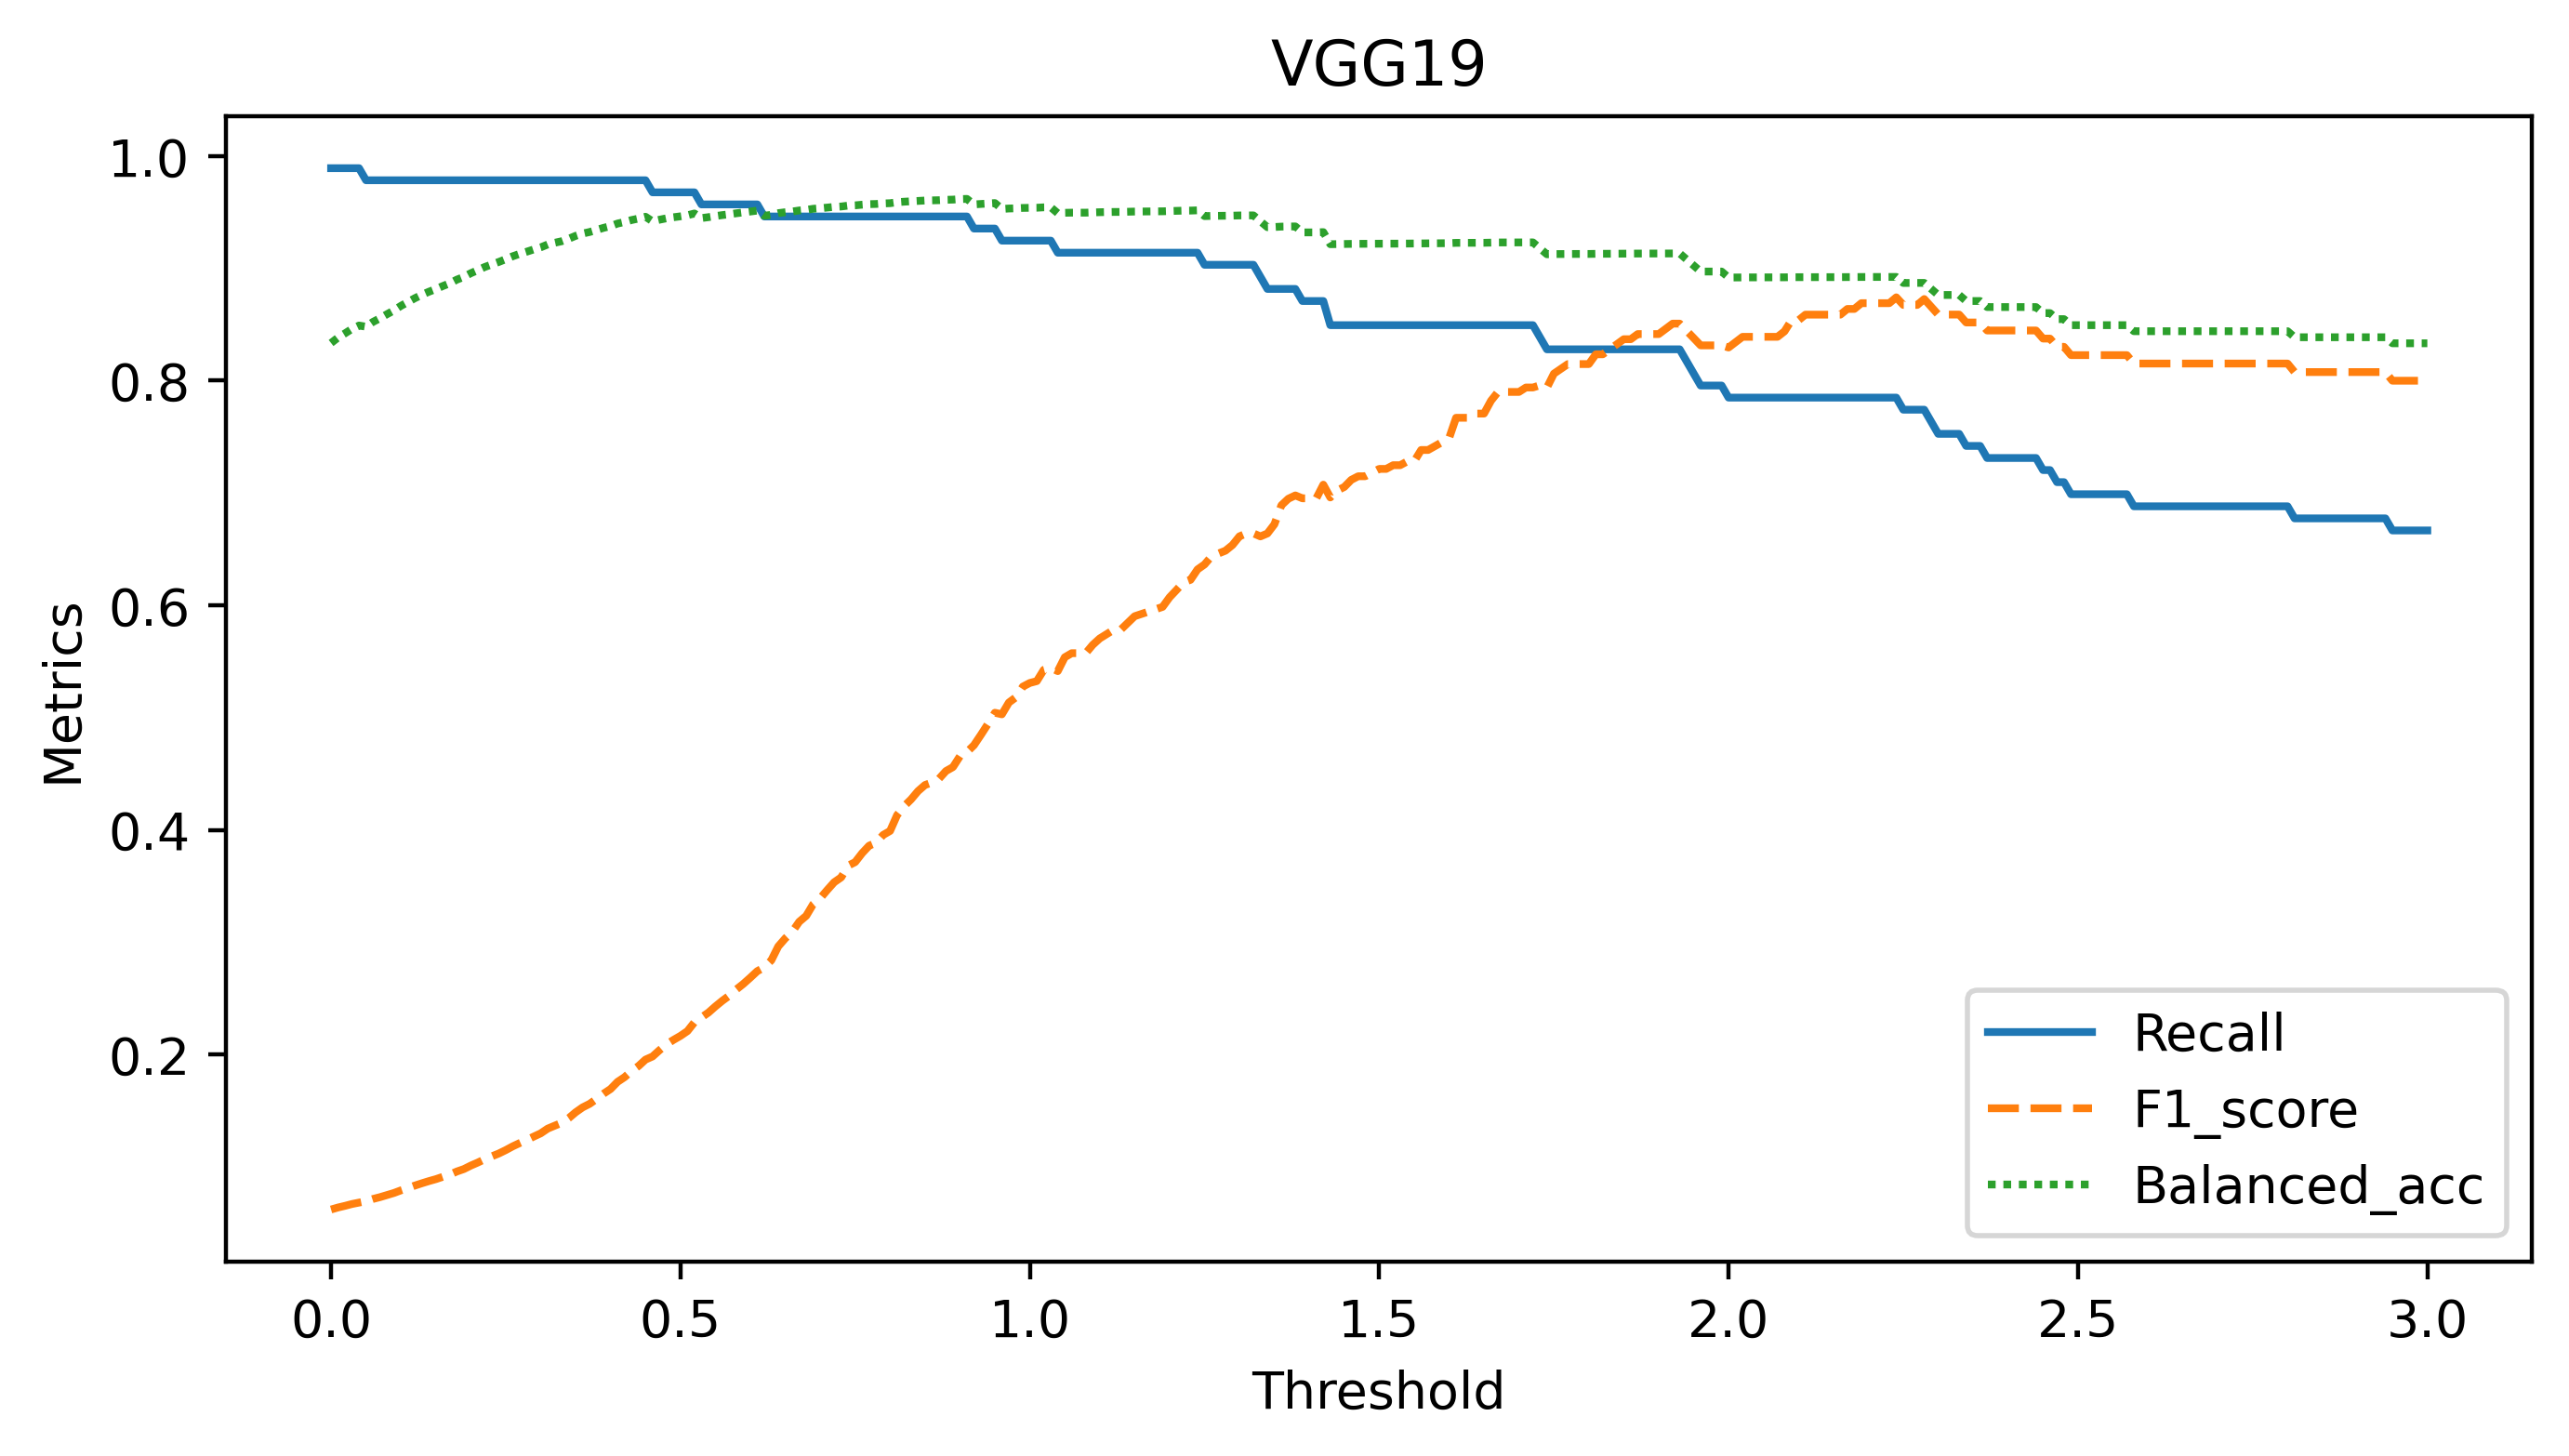

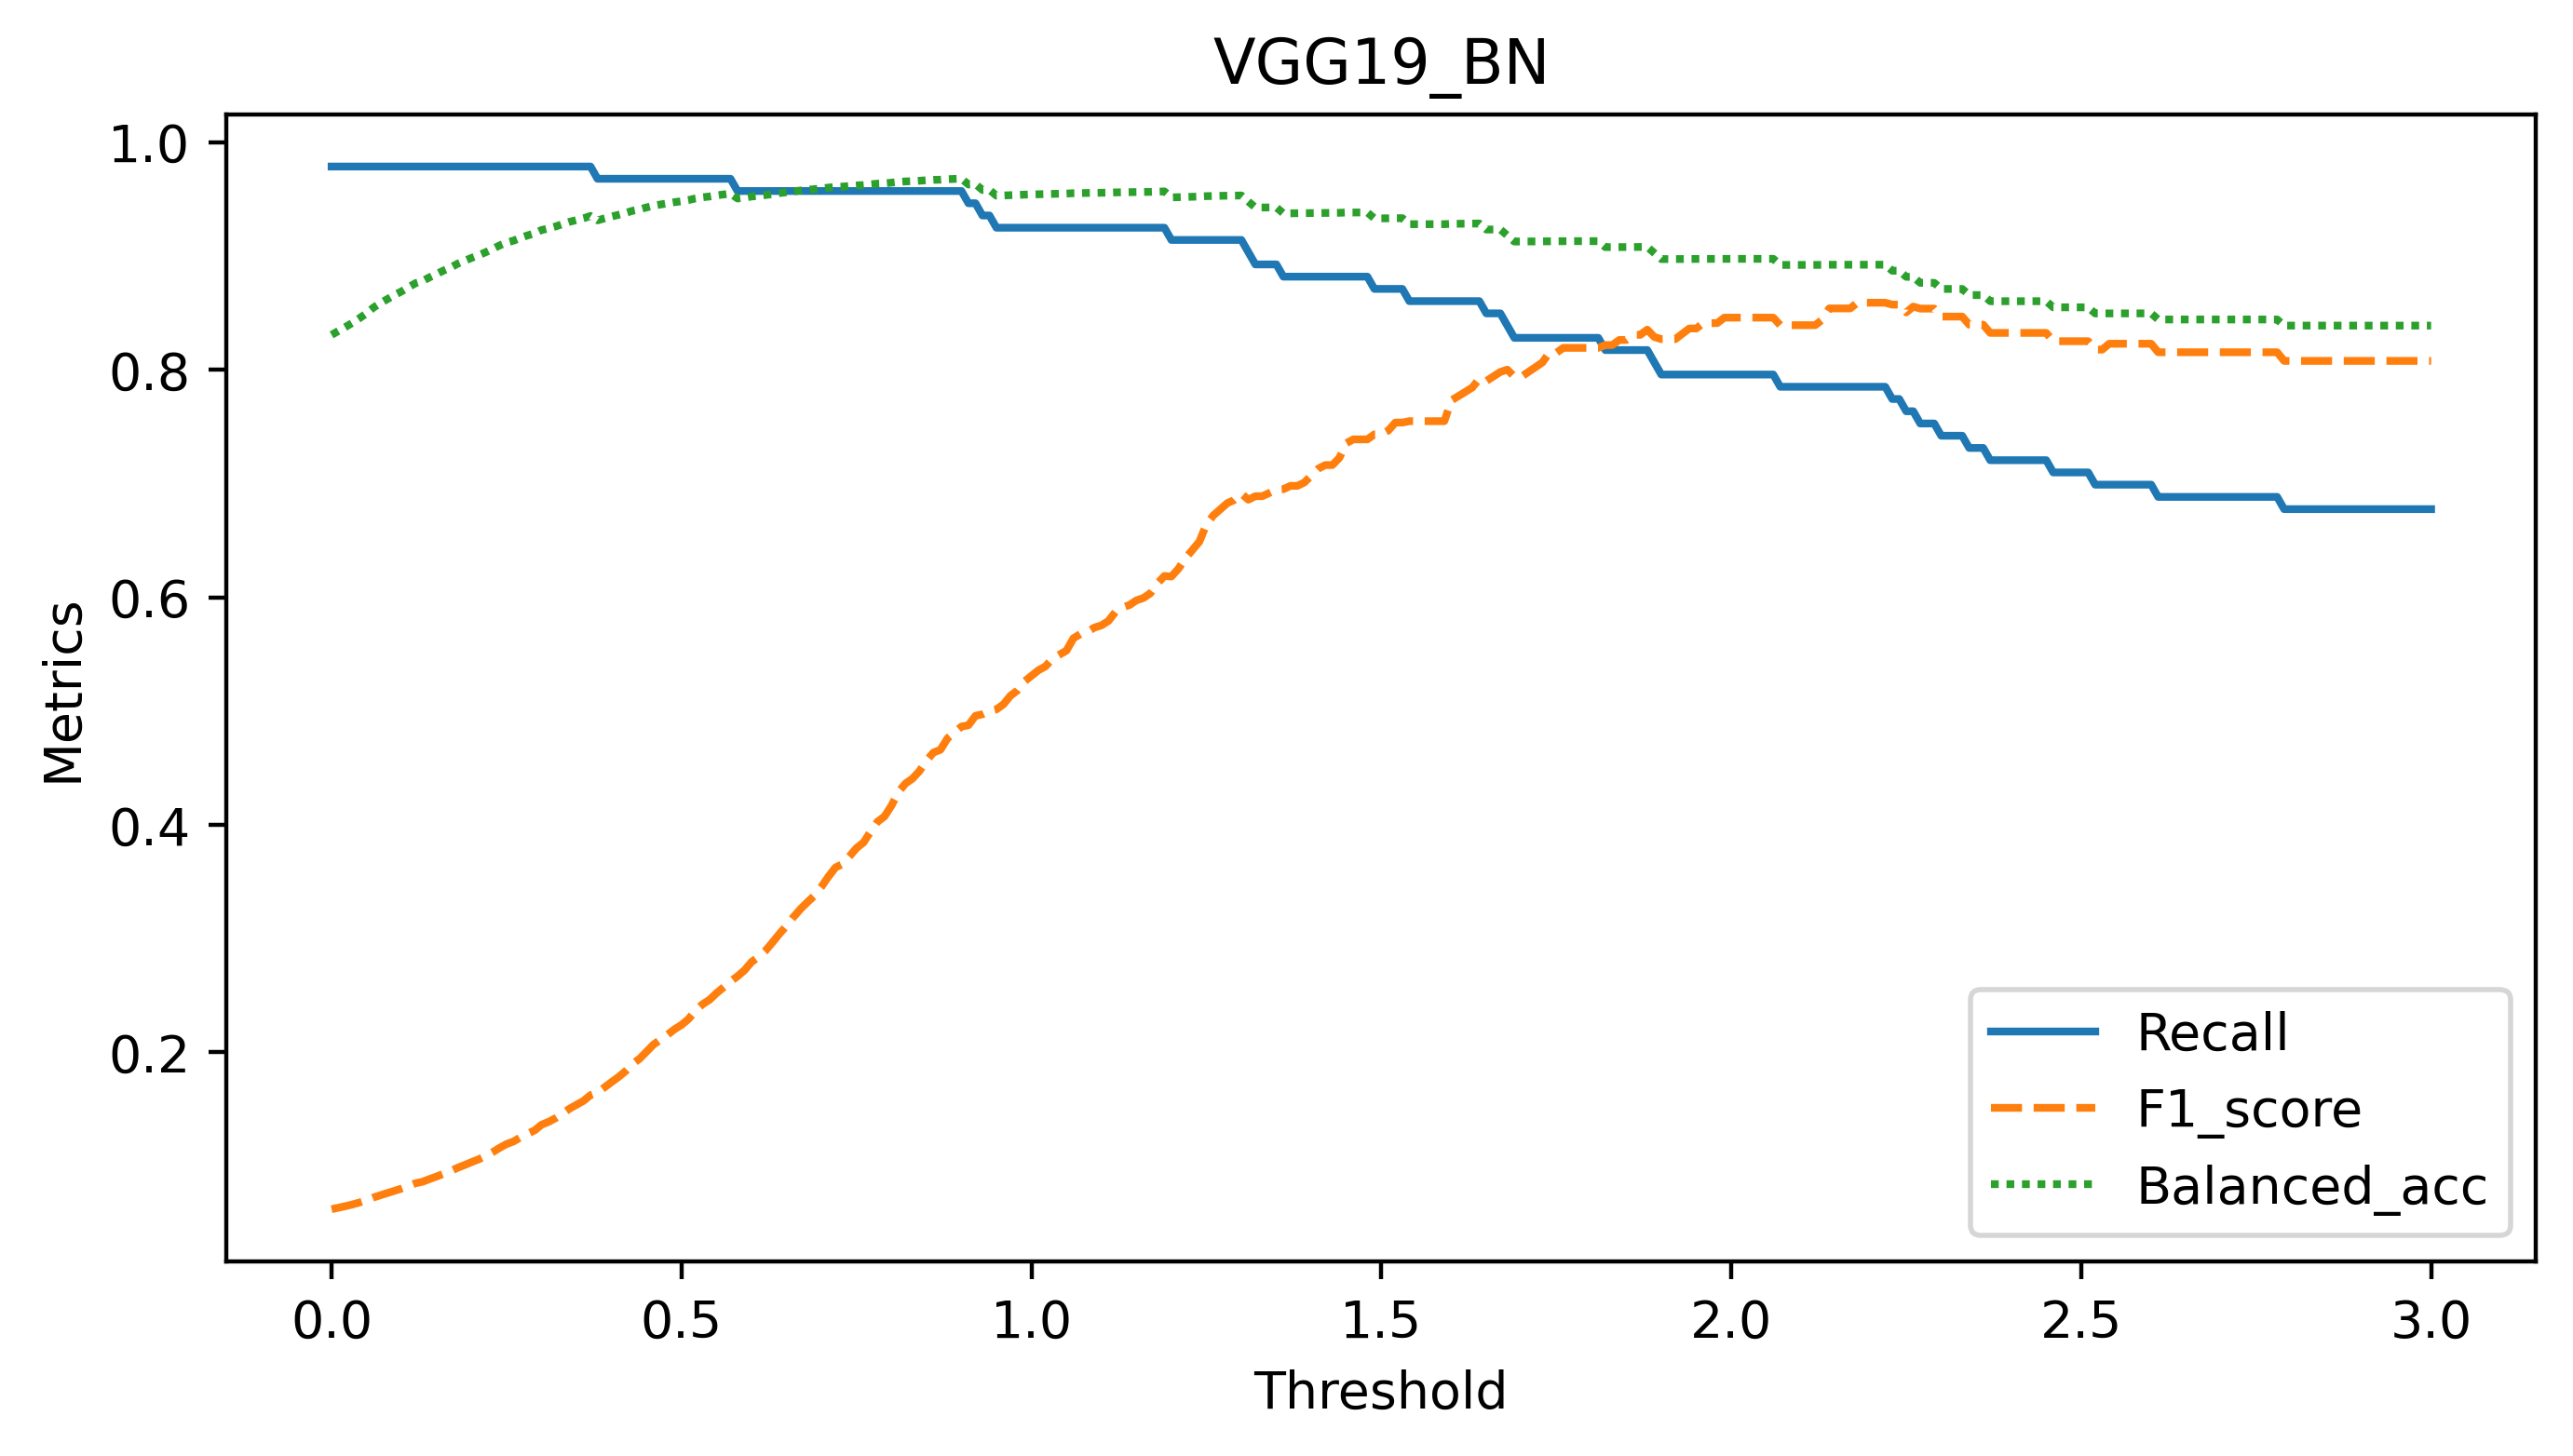

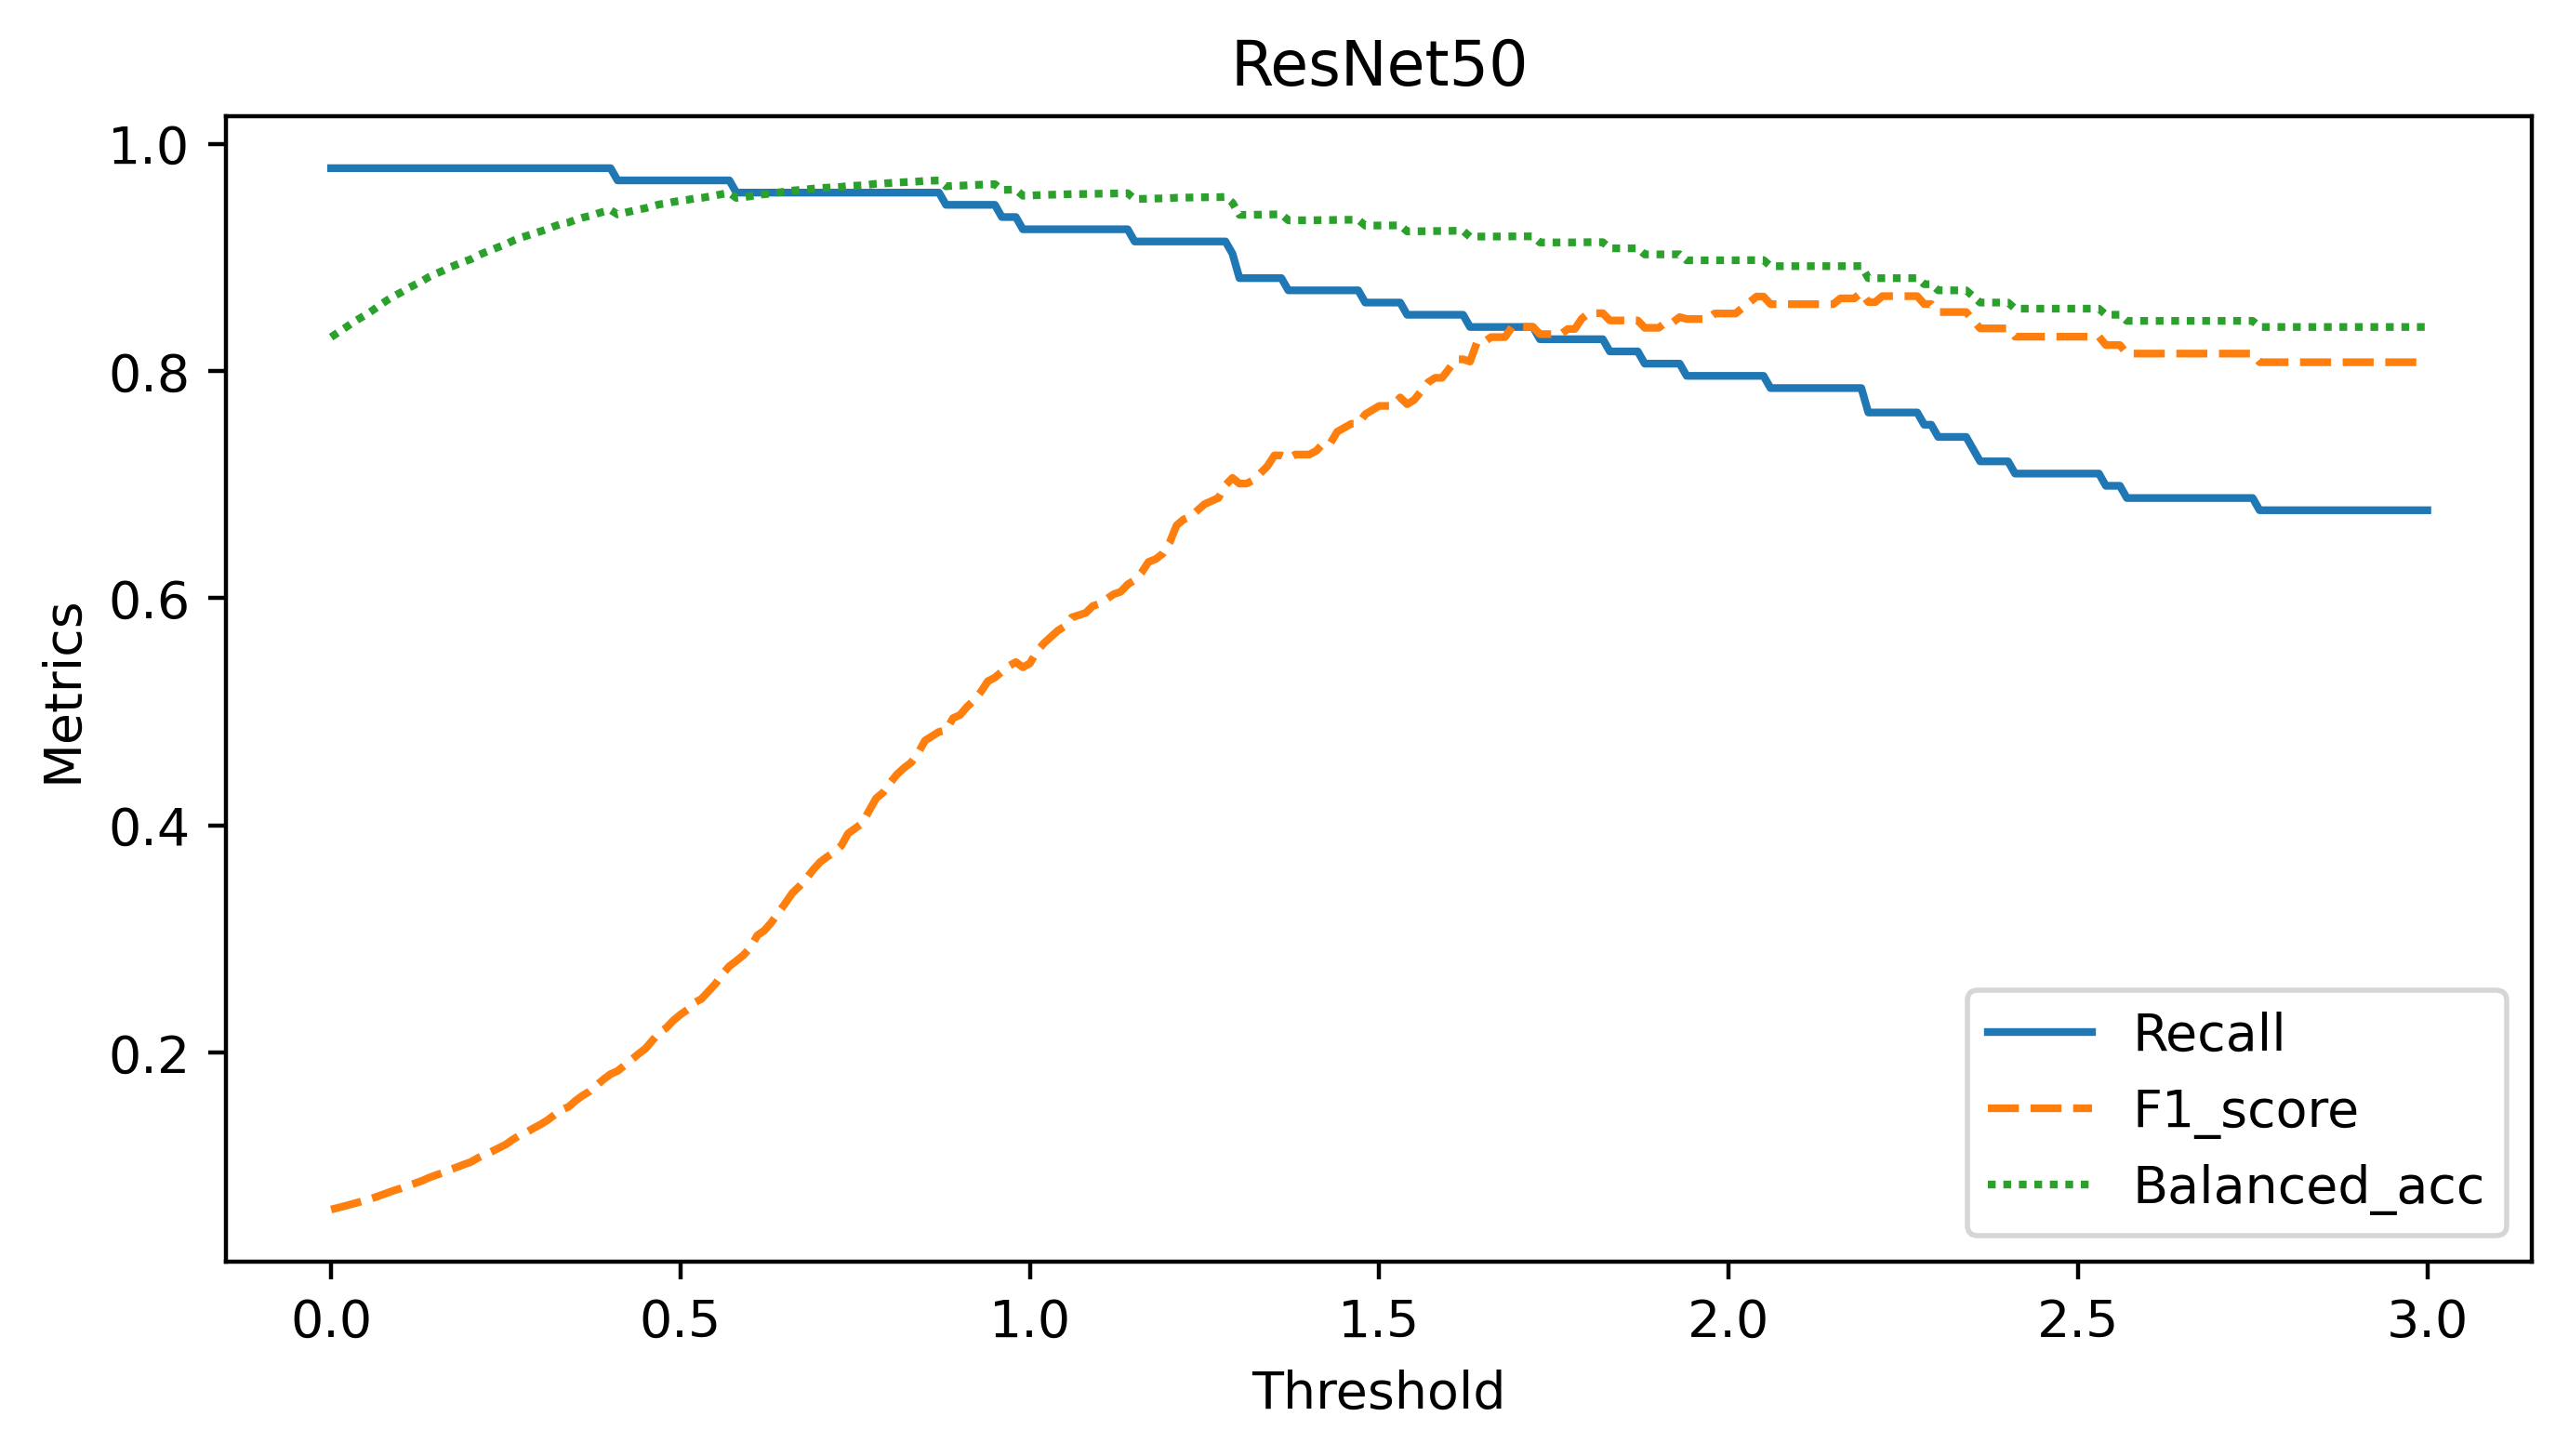

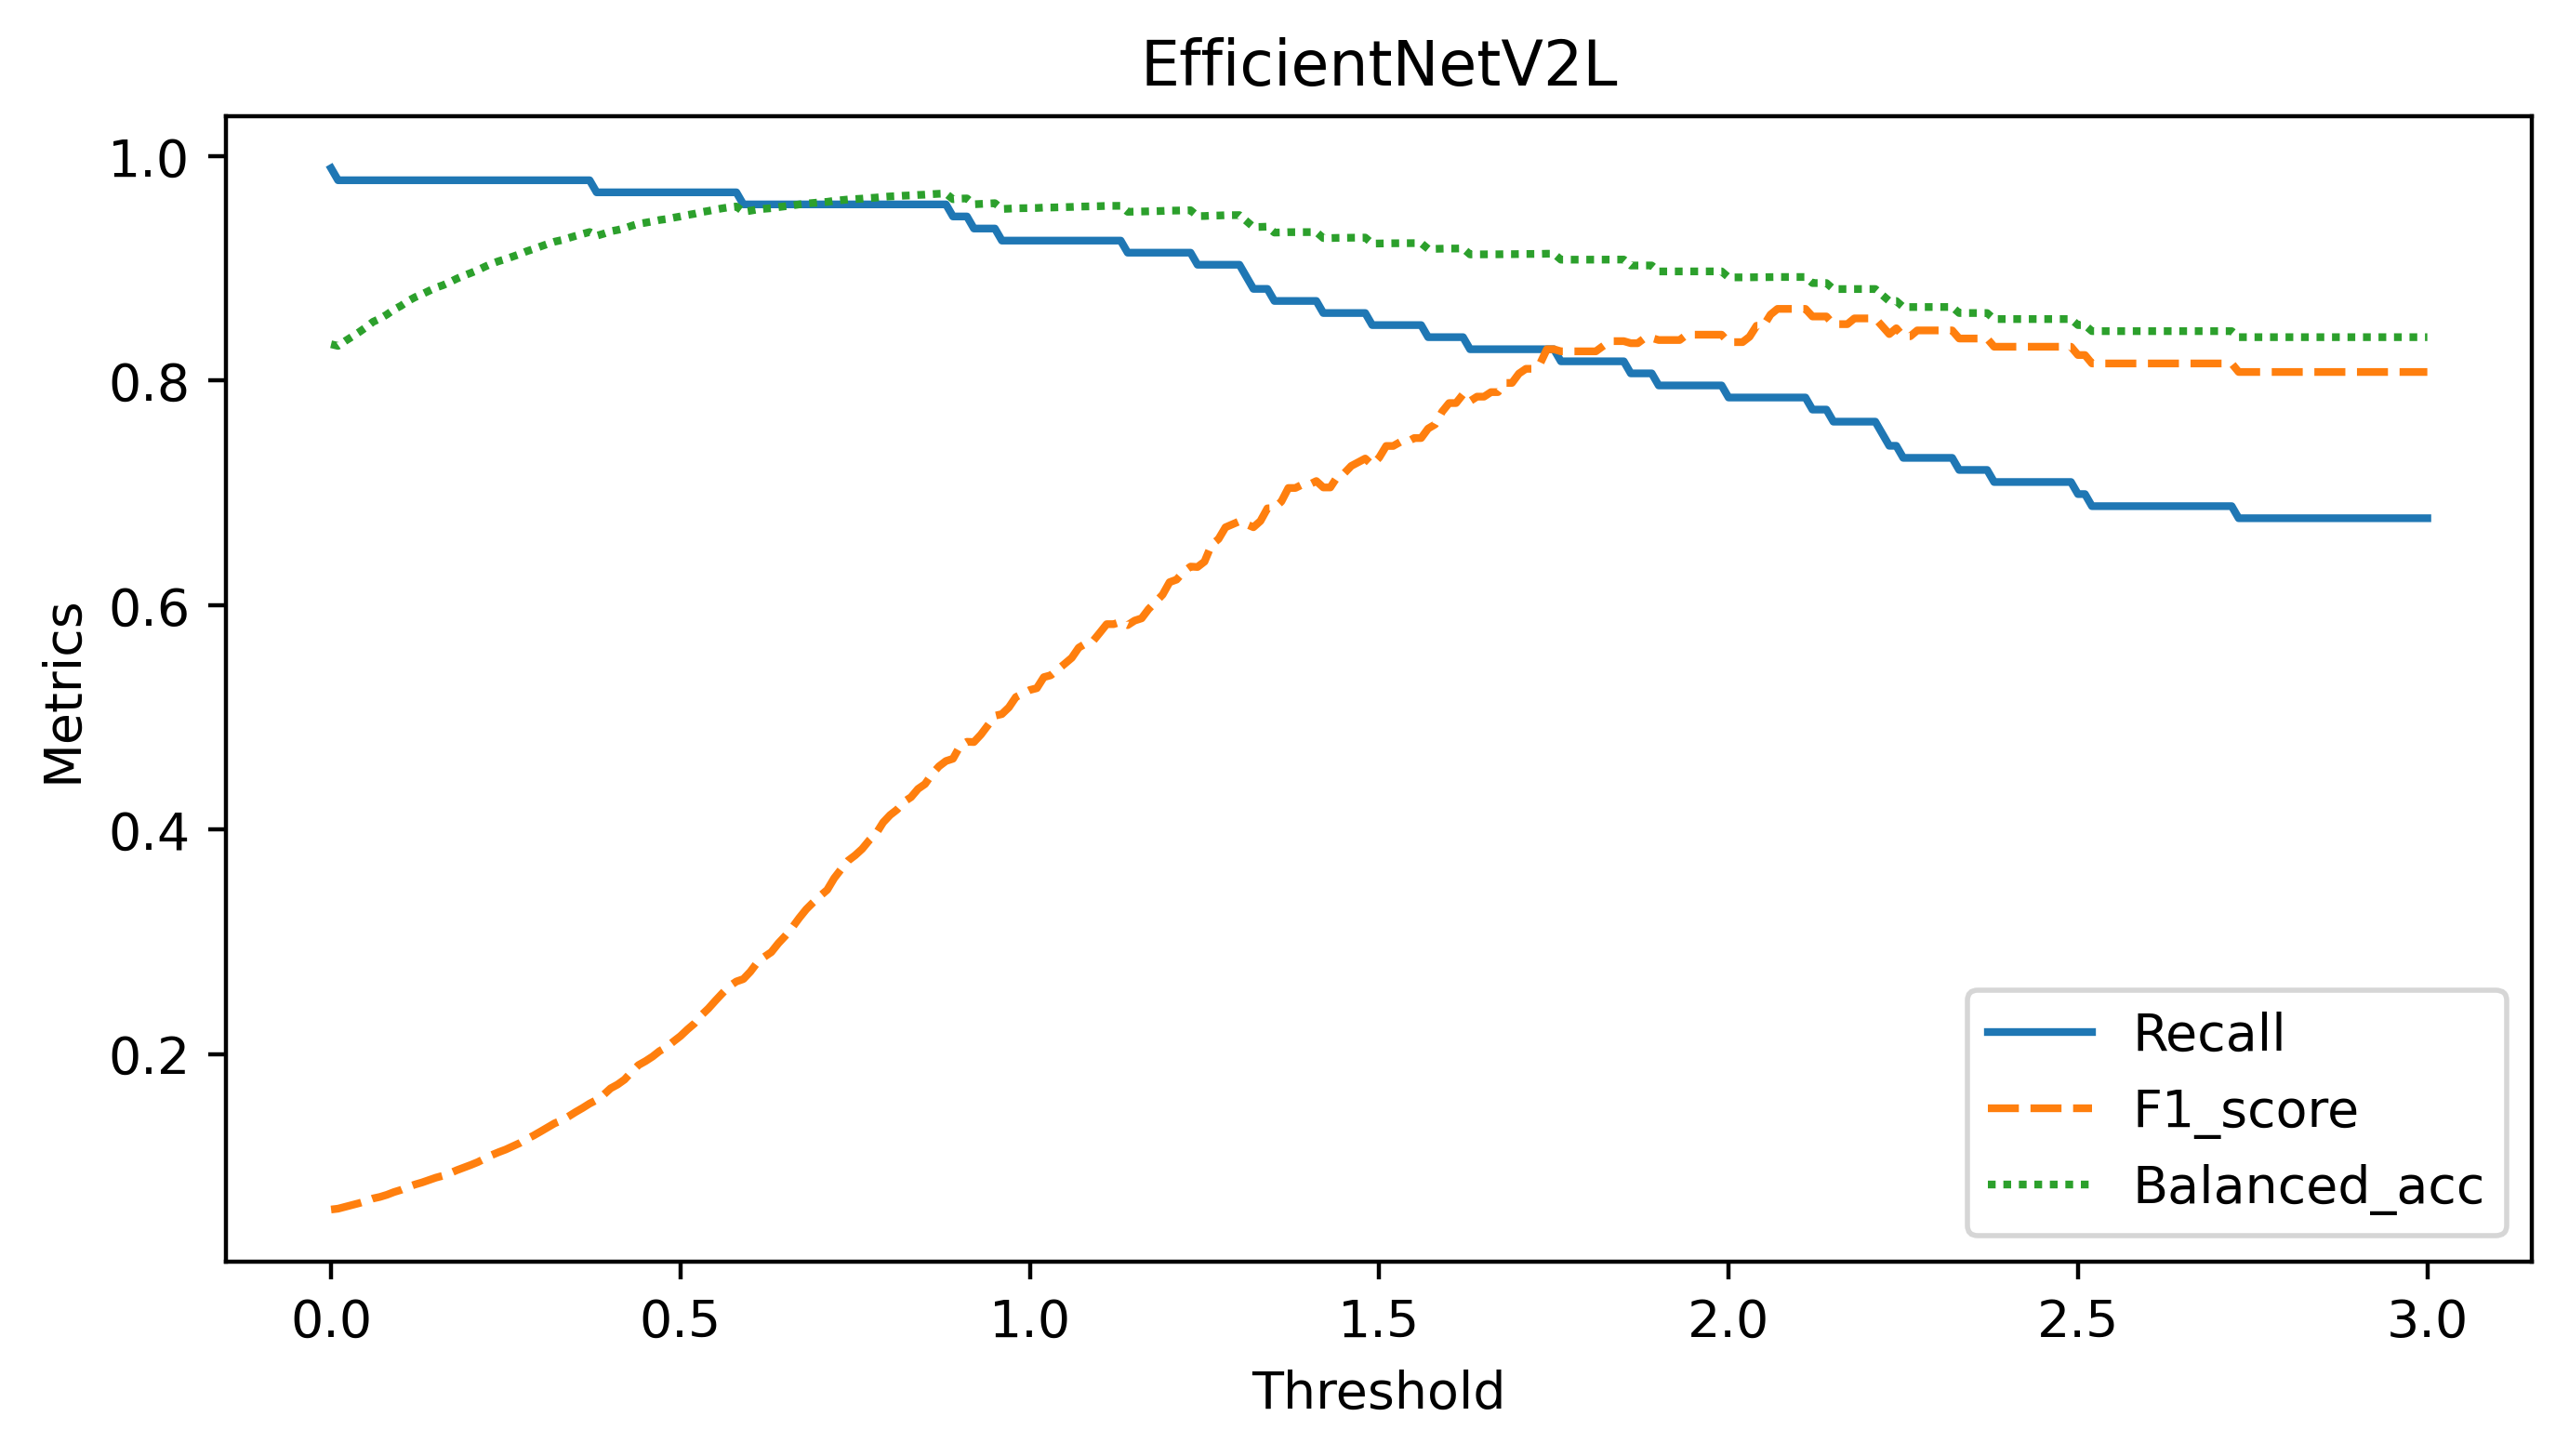

In [9]:
for k, v in res.items():
    fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=400)
    sns.lineplot(data=v, ax=ax)
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Metrics")
    ax.set_title(k)
    plt.show()
    fig.savefig(fname=save_folder / f"{k}_threshold.png")

In [10]:
for k, v in res.items():
    print(f"{k}: {v.index[np.argmax(v['F1_score'])]}")

VGG19: 2.24
VGG19_BN: 2.18
ResNet50: 2.19
EfficientNetV2L: 2.07


In [16]:
y_pred_if = {
    "VGG19": pd.read_csv(
        "./results/vgg19_vgg19/20230510_172958_isolation_forest_data.csv", index_col="img_no"
    ),
    "VGG19_BN": pd.read_csv(
        "./results/vgg19_bn_vgg19/20230525_045131_isolation_forest_data.csv", index_col="img_no"
    ),
    "ResNet50": pd.read_csv(
        "./results/resnet50_vgg19/20230514_213740_isolation_forest_data.csv", index_col="img_no"
    ),
    "EfficientNetV2L": pd.read_csv(
        "./results/efficientnetv2l_vgg19/20230525_194238_isolation_forest_data.csv", index_col="img_no"
    ),
}
y_pred_lb = {}
for k, loss in losses.items():
    loss_mean = np.mean(loss)
    loss_std = np.std(loss)
    loss_threshold = loss_mean + 2.15 * loss_std
    y_pred_lb[k] = loss >= loss_threshold

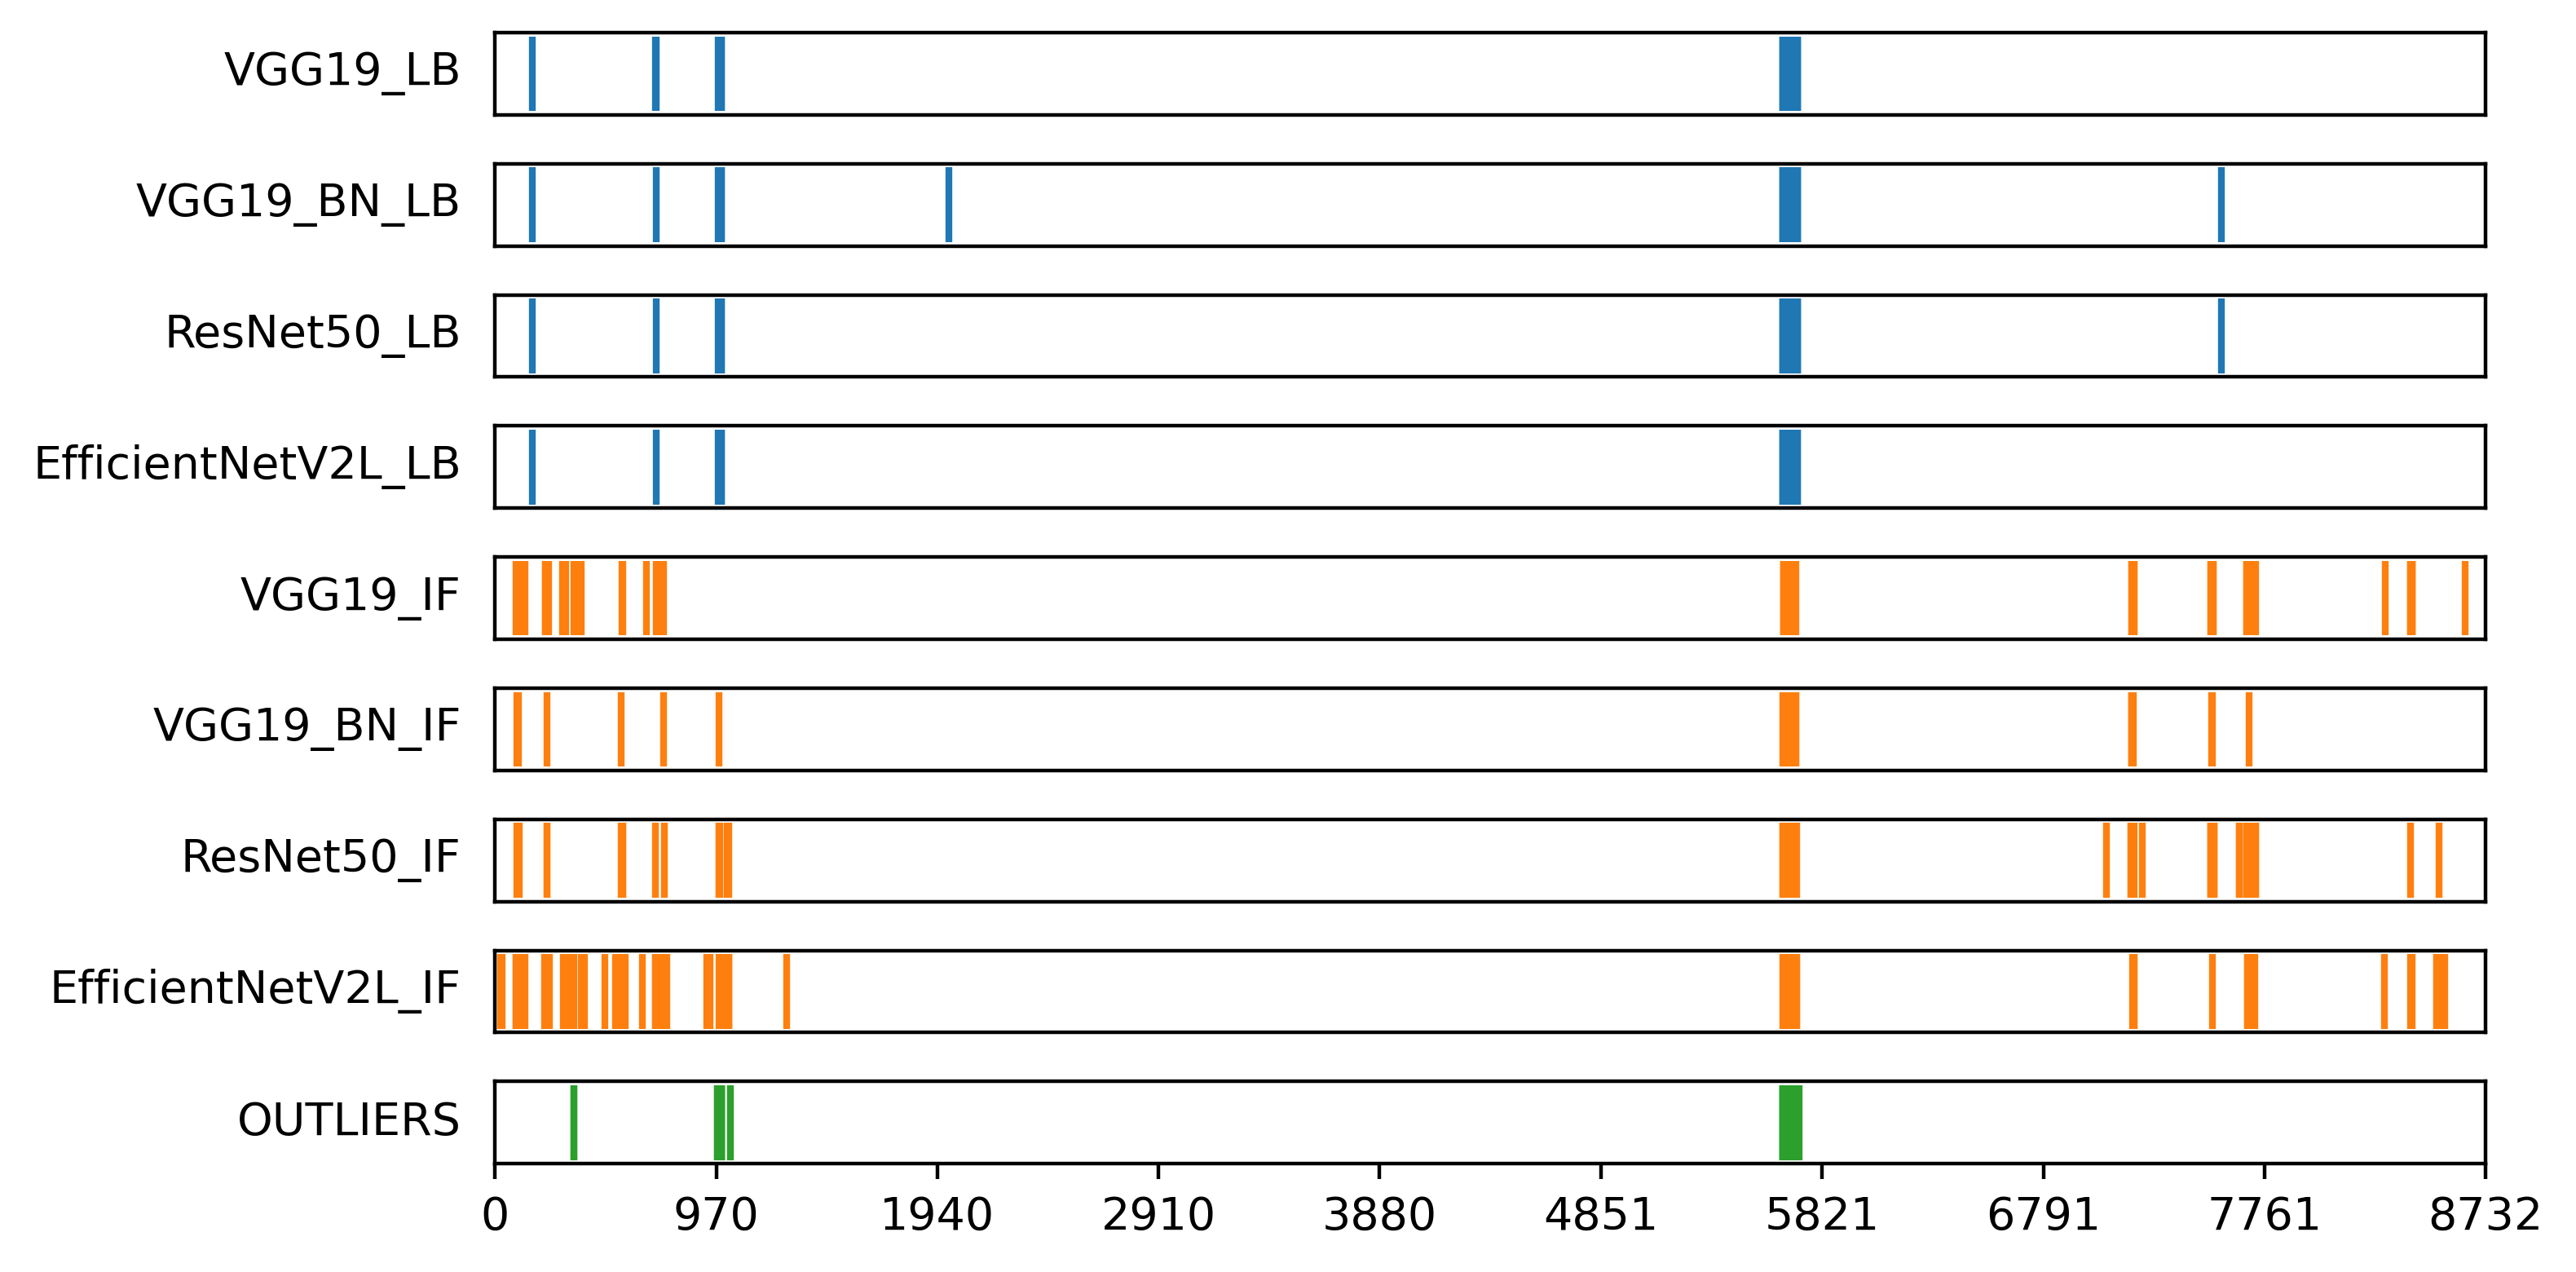

In [106]:
fig, axs = plt.subplots(9, 1, figsize=(8, 4), dpi=400, tight_layout=True, sharex=True)
for i, (k, v) in enumerate(y_pred_lb.items()):
    axs[i].vlines(x=v[v["loss"]].index, ymin=0, ymax=1, color="tab:blue")
    axs[i].tick_params(axis="x", length=0)
    axs[i].set_yticks([])
    axs[i].set_ylabel(f"{k}_LB", rotation="horizontal", ha="right", va="center")
for i, (k, v) in enumerate(y_pred_if.items()):
    axs[i+4].vlines(x=v[v["outlier"]].index, ymin=0, ymax=1, color="tab:orange")
    axs[i+4].tick_params(axis="x", length=0)
    axs[i+4].set_yticks([])
    axs[i+4].set_ylabel(f"{k}_IF", rotation="horizontal", ha="right", va="center")
axs[-1].vlines(x=y_true[y_true].index, ymin=0, ymax=1, color="tab:green")
axs[-1].set_xlim(min(y_true.index), max(y_true.index))
axs[-1].set_xticks(np.linspace(min(y_true.index), max(y_true.index), 10, endpoint=True, dtype="int"))
axs[-1].set_yticks([])
axs[-1].set_ylabel("OUTLIERS", rotation="horizontal", ha="right", va="center")

plt.show()
fig.savefig(fname=save_folder / "outlier_comparison.png")

In [60]:
outliers = pd.DataFrame()
outliers["TRUE"] = y_true
for k, v in y_pred_lb.items():
    outliers[f"{k}_LB"] = v["loss"]
for k, v in y_pred_if.items():
    outliers[f"{k}_IF"] = v["outlier"]

In [171]:
x = outliers[outliers["TRUE"]].sum(axis=1)
for k, v in x.index.groupby(x).items():
    print(k-1, list(v))

0 [974, 975, 980, 984, 990, 991, 994, 1031, 5647, 5702, 5713, 5715, 5716, 5717, 5718, 5719]
1 [345, 346]
3 [989, 5701, 5714]
4 [983, 986, 987, 988, 992, 993, 5648, 5664, 5700, 5703, 5710, 5711, 5712]
5 [982, 5650, 5651, 5663, 5665, 5705, 5709]
6 [985, 5706, 5708]
7 [981, 5649, 5666, 5667, 5704, 5707]
8 [5652, 5653, 5654, 5655, 5656, 5657, 5658, 5659, 5660, 5661, 5662, 5668, 5669, 5670, 5671, 5672, 5673, 5674, 5675, 5676, 5677, 5678, 5679, 5680, 5681, 5682, 5683, 5684, 5685, 5686, 5687, 5688, 5689, 5690, 5691, 5692, 5693, 5694, 5695, 5696, 5697, 5698, 5699]


In [168]:
x2 = outliers[outliers["TRUE"] == False].sum(axis=1)
for k, v in x2.index.groupby(x2).items():
    print(k, list(v))

0 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 121, 122, 123, 124, 126, 127, 128, 130, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 216, 217, 218, 222, 232, 236, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 

In [199]:
df = y_pred["VGG19_BN"]
df[df["loss"]].index

Int64Index([ 163,  707,  979,  981,  982,  983,  985,  986,  987,  988,  989,
             992,  993, 1991, 5648, 5649, 5650, 5651, 5652, 5653, 5654, 5655,
            5656, 5657, 5658, 5659, 5660, 5661, 5662, 5663, 5664, 5665, 5666,
            5667, 5668, 5669, 5670, 5671, 5672, 5673, 5674, 5675, 5676, 5677,
            5678, 5679, 5680, 5681, 5682, 5683, 5684, 5685, 5686, 5687, 5688,
            5689, 5690, 5691, 5692, 5693, 5694, 5695, 5696, 5697, 5698, 5699,
            5703, 5704, 5705, 5706, 5707, 5708, 5709, 5710, 5711, 5712, 5714,
            7573],
           dtype='int64', name='img_no')